In [47]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools
import api as pyq 
import importlib
import os
import h5py
import pdb

print(pyq.__file__)


/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py


In [48]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2.", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.RHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)


def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf, 2, 2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc


def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASCI(mf, 2, 2)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc


def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

for fname in ['scf.hdf5','ci.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
run_scf(scf_checkfile)
# run_casci(scf_checkfile, ci_checkfile)

converged SCF energy = -1.08989374734689


In [49]:
# Jastrow optimization
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, verbose=False)

In [50]:
# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

,energy,iteration,error,fname
0,-1.093219,0,0.003007,sj.hdf5
1,-1.111755,1,0.001305,sj.hdf5


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/mc.py(110)fixed_initial_guess()
    108     import pdb
    109     pdb.set_trace()
--> 110     if hasattr(mol, "a"):
    111         epos = PeriodicConfigs(epos, mol.lattice_vectors())
    112     else:



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(293)gradient_value()
    291             d_mo_vals = d_mo[:, :, slater_det._det_occup[s]]
    292             pdb.set_trace()
--> 293             ratios = gpu.cp.einsum(
    294                 "eidj,idj->eid",
    295                 d_mo_vals,



ipdb>  c


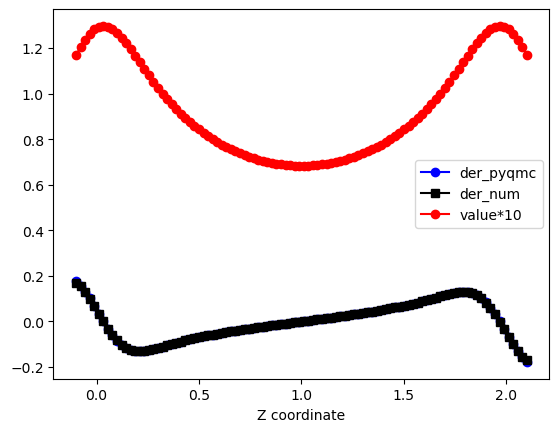

> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/bosonwf.py(327)gradient_value()
    325 
    326         pdb.set_trace()
--> 327         return derivatives, values, val
    328 
    329 



In [ ]:
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, slater
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, slater] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC
ABDMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", accumulators = {"energy": True}, verbose=False, nsteps = 500, branchtime = 10, tstep= 0.02, nconfig=100)
# ABDMC("scf.hdf5", "dmc.hdf5", load_parameters="sj.hdf5", ci_checkfile=ci_checkfile, accumulators = {"energy": True}, verbose=False, nsteps = 500, branchtime = 10, tstep= 0.02)